## **Data Load**

In [3]:
# import all library
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import timeit
import time
import tracemalloc
from memory_profiler import memory_usage

In [4]:
mat_content = sio.loadmat('assets/face.mat')
# mat_content # Let's see the content...

face_data = mat_content['X']
face_labels = mat_content['l']

x_train, x_test, y_train, y_test = [], [], [], []

n_classes = 52
images_per_class = 10

for i in range(n_classes):
    start_idx = i * images_per_class
    end_idx = start_idx + images_per_class

    x_train.append(face_data[:, start_idx:start_idx+8])
    x_test.append(face_data[:, start_idx+8:end_idx])

    y_train.append(face_labels[:, start_idx:start_idx+8])
    y_test.append(face_labels[:, start_idx+8:end_idx])

x_train, x_test = np.hstack(x_train), np.hstack(x_test)
y_train, y_test = np.hstack(y_train), np.hstack(y_test)

x_train = x_train.astype(np.int64)
x_test = x_test.astype(np.int64)

# Output the shapes of the training and testing sets
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (2576, 416)
Test set shape: (2576, 104)


## **Q2. Incremental PCA**

creating subdatasets

In [5]:
x_sub1, x_sub2, x_sub3, x_sub4 = [], [], [], []
y_sub1, y_sub2, y_sub3, y_sub4 = [], [], [], []

n_classes = 52
images_per_class = 8

for i in range(n_classes):
  x_sub1.append(x_train[:,i*images_per_class :i*images_per_class + 2])
  x_sub2.append(x_train[:,i*images_per_class+2 :i*images_per_class + 4])
  x_sub3.append(x_train[:,i*images_per_class+4 :i*images_per_class + 6])
  x_sub4.append(x_train[:,i*images_per_class+6 :i*images_per_class + 8])

  y_sub1.append(y_train[:,i*images_per_class :i*images_per_class + 2])
  y_sub2.append(y_train[:,i*images_per_class+2 :i*images_per_class + 4])
  y_sub3.append(y_train[:,i*images_per_class+4 :i*images_per_class + 6])
  y_sub4.append(y_train[:,i*images_per_class+6 :i*images_per_class + 8])

x_sub1, x_sub2, x_sub3, x_sub4 = np.hstack(x_sub1), np.hstack(x_sub2), np.hstack(x_sub3), np.hstack(x_sub4)
y_sub1, y_sub2, y_sub3, y_sub4 = np.hstack(y_sub1), np.hstack(y_sub2), np.hstack(y_sub3), np.hstack(y_sub4)

x_subs = [x_sub1, x_sub2, x_sub3, x_sub4]
y_subs = [y_sub1, y_sub2, y_sub3, y_sub4]

1. Incremental learning

In [10]:
def ipca_nn(n_components, x_subs, y_subs, x_test):
  # Measure memory usage and execution time
  # tracemalloc.start() 

  ipca = IncrementalPCA(n_components = n_components)
  
  run_time = 0
  peak_memory_usage = []

  for subset in x_subs:
    # Measure runtime and memory for each batch
    start_time = time.time()
    mem_usage = memory_usage((ipca.partial_fit, (subset.T,)), max_usage=True)
    end_time = time.time()
    
    run_time += end_time - start_time
    peak_memory_usage.append(mem_usage)

  peak_memory = max(peak_memory_usage)
  # current_memory, peak_memory = tracemalloc.get_traced_memory()
  tracemalloc.stop()
  run_time /= len(x_subs)
  
  # Project train data
  W_train_sub1 = ipca.transform(x_subs[0].T).T
  W_train_sub2 = ipca.transform(x_subs[1].T).T
  W_train_sub3 = ipca.transform(x_subs[2].T).T
  W_train_sub4 = ipca.transform(x_subs[3].T).T
  W_train = np.vstack((W_train_sub1.T, W_train_sub2.T, W_train_sub3.T, W_train_sub4.T))

  # Train NN model
  nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
  y_train_combined = np.concatenate([y_subs[0].T, y_subs[1].T, y_subs[2].T, y_subs[3].T])
  nn.fit(W_train, y_train_combined.ravel())

  # Project test data and predict
  W_test = ipca.transform(x_test.T).T
  y_pred = nn.predict(W_test.T)

  return y_pred, run_time, peak_memory

ipca_y_pred, ipca_run_time, ipca_peak_memory = ipca_nn(20, x_subs, y_subs, x_test)

accuracy = accuracy_score(y_test.T, ipca_y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Peak memory usage: {ipca_peak_memory} MB")
print(f"Execution Time: {ipca_run_time:.8f} seconds")

Accuracy: 56.73%
Peak memory usage: 292.90234375 MB
Execution Time: 0.78967363 seconds


Define pca and nn classifier

In [19]:
def pca_nn(n_components, x_train, y_train, x_test):
    # Measure memory usage and execution time
    pca = PCA(n_components = n_components)
    pca.fit(x_train.T)

    start_time = time.time()
    peak_memory = memory_usage((pca.fit, (x_train.T,)), max_usage=True)
    end_time = time.time()
    run_time = end_time - start_time

    # Project train data
    W_train = pca.transform(x_train.T).T

    # Train NN model
    nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
    nn.fit(W_train.T, y_train.reshape(-1))

    # Project test data and predict
    W_test = pca.transform(x_test.T).T
    y_pred = nn.predict(W_test.T)

    return y_pred, run_time, peak_memory

ipca_y_pred, ipca_run_time, ipca_peak_memory = pca_nn(20, x_train, y_train, x_test)

accuracy = accuracy_score(y_test.T, ipca_y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Peak memory usage: {ipca_peak_memory} MB")
print(f"Execution Time: {ipca_run_time:.8f} seconds")

Accuracy: 56.73%
Peak memory usage: 298.39453125 MB
Execution Time: 0.85532880 seconds


2. Batch PCA

In [24]:
batch_y_pred, batch_run_time, batch_peak_memory = pca_nn(15, x_train, y_train, x_test)

accuracy = accuracy_score(y_test.T, batch_y_pred)
print(f"Accuracy : {accuracy * 100:.2f}%")
print(f"Peak memory usage: {batch_peak_memory} MB")
print(f"Execution Time: {batch_run_time:.8f} seconds")

Accuracy : 49.04%
Peak memory usage: 298.1015625 MB
Execution Time: 0.79736590 seconds


3. PCA with first train subset

In [29]:
# Input of pca_nn: x_sub1
sub1_y_pred, sub1_run_time, sub1_peak_memory = pca_nn(5, x_sub1, y_sub1, x_test)

accuracy = accuracy_score(y_test.T, sub1_y_pred)
print(f"Accuracy : {accuracy * 100:.2f}%")
print(f"Peak memory usage: {sub1_peak_memory / 10**6} MB")
print(f"Execution Time: {sub1_run_time:.8f} seconds")

Accuracy : 17.31%
Peak memory usage: 0.000297640625 MB
Execution Time: 1.08441710 seconds


Show result

In [50]:
# Get Average Result
def avg_results(num_iter, func, num_bases, x_train, y_train, x_test, y_test):
    accuracy_avg, run_time_avg, current_memory_avg, peak_memory_avg = 0,0,0,0

    for i in range(num_iter):
        y_pred, run_time, current_memory, peak_memory = func(num_bases, x_train, y_train, x_test)
        accuracy = accuracy_score(y_test.T, y_pred) * 100
        
        accuracy_avg += accuracy
        run_time_avg += run_time
        current_memory_avg += current_memory
        peak_memory_avg += peak_memory
    
    accuracy_avg /= num_iter
    run_time_avg /= num_iter
    current_memory_avg /= num_iter
    peak_memory_avg /= num_iter

    return accuracy_avg, run_time_avg, current_memory_avg, peak_memory_avg

In [71]:
num_base_vecs = []

ipca_acc_result = []
batch_acc_result = []
sub1_acc_result = []

ipca_runtime_result = []
batch_runtime_result = []
sub1_runtime_result = []

ipca_cur_mem_result = []
batch_cur_mem_result = []
sub1_cur_mem_result = []

ipca_peak_mem_result = []
batch_peak_mem_result = []
sub1_peak_mem_result = []


for i in range(1, 11):
    num_bases = 5*i
    num_base_vecs.append(num_bases)
    
    # Get each PCA result
    ipca_accuracy, ipca_run_time, ipca_current_memory, ipca_peak_memory = avg_results(20, ipca_nn, num_bases, x_subs, y_subs, x_test, y_test)
    batch_accuracy, batch_run_time, batch_current_memory, batch_peak_memory = avg_results(20, pca_nn, num_bases, x_train, y_train, x_test, y_test)
    sub1_accuracy, sub1_run_time, sub1_current_memory, sub1_peak_memory = avg_results(20, pca_nn, num_bases, x_sub1, y_sub1, x_test, y_test)

    # accuracy arrays
    ipca_acc_result.append(ipca_accuracy)
    batch_acc_result.append(batch_accuracy)
    sub1_acc_result.append(sub1_accuracy)

    # runtime arrays -> seconds
    ipca_runtime_result.append(ipca_run_time)
    batch_runtime_result.append(batch_run_time)
    sub1_runtime_result.append(sub1_run_time)
    

    # peak memory arrays -> Mega Bite (MB)
    ipca_peak_mem_result.append(ipca_peak_memory / 10**6)
    batch_peak_mem_result.append(batch_peak_memory / 10**6)
    sub1_peak_mem_result.append(sub1_peak_memory / 10**6)

    ipca_cur_mem_result.append(ipca_current_memory / 10**6)
    batch_cur_mem_result.append(batch_current_memory / 10**6)
    sub1_cur_mem_result.append(sub1_current_memory / 10**6)


In [75]:
num_base_vecs = []

ipca_acc_result = []
batch_acc_result = []
sub1_acc_result = []

ipca_runtime_result = []
batch_runtime_result = []
sub1_runtime_result = []

ipca_cur_mem_result = []
batch_cur_mem_result = []
sub1_cur_mem_result = []

ipca_peak_mem_result = []
batch_peak_mem_result = []
sub1_peak_mem_result = []


for i in range(1, 11):
    num_bases = 5*i
    num_base_vecs.append(num_bases)
    
    # Get each PCA result
    ipca_y_pred, ipca_run_time, ipca_current_memory, ipca_peak_memory = ipca_nn(num_bases, x_subs, y_subs, x_test)
    batch_y_pred, batch_run_time, batch_current_memory, batch_peak_memory = pca_nn(num_bases, x_train, y_train, x_test)
    sub1_y_pred, sub1_run_time, sub1_current_memory, sub1_peak_memory = pca_nn(num_bases, x_sub1, y_sub1, x_test)
    
    # accuracy: %
    ipca_accuracy = accuracy_score(y_test.T, ipca_y_pred) * 100
    batch_accuracy = accuracy_score(y_test.T, batch_y_pred) * 100
    sub1_accuracy = accuracy_score(y_test.T, sub1_y_pred) * 100

    # accuracy arrays
    ipca_acc_result.append(ipca_accuracy)
    batch_acc_result.append(batch_accuracy)
    sub1_acc_result.append(sub1_accuracy)

    # runtime arrays -> seconds
    ipca_runtime_result.append(ipca_run_time)
    batch_runtime_result.append(batch_run_time)
    sub1_runtime_result.append(sub1_run_time)
    

    # peak memory arrays -> Mega Bite (MB)
    ipca_peak_mem_result.append(ipca_peak_memory / 10**6)
    batch_peak_mem_result.append(batch_peak_memory / 10**6)
    sub1_peak_mem_result.append(sub1_peak_memory / 10**6)

    ipca_cur_mem_result.append(ipca_current_memory / 10**6)
    batch_cur_mem_result.append(batch_current_memory / 10**6)
    sub1_cur_mem_result.append(sub1_current_memory / 10**6)


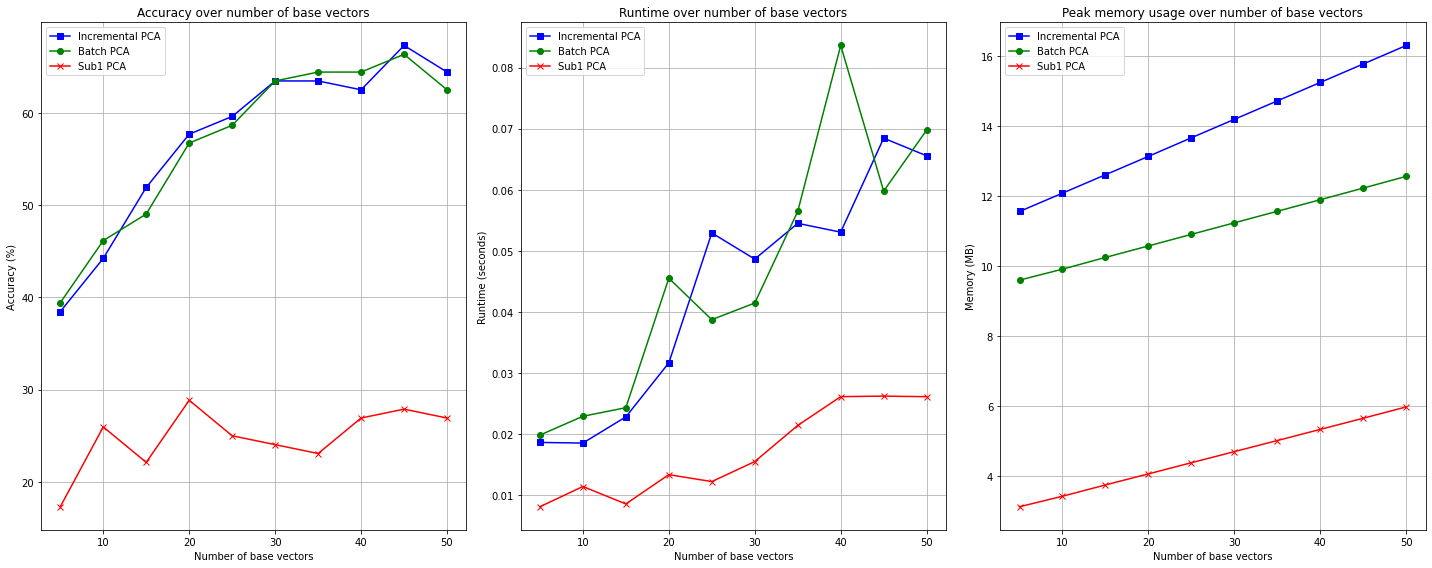

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Plot accuracy on the first subplot
axes[0].plot(num_base_vecs, ipca_acc_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[0].plot(num_base_vecs, batch_acc_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[0].plot(num_base_vecs, sub1_acc_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[0].set_xlabel('Number of base vectors')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Accuracy over number of base vectors')
axes[0].legend()
axes[0].grid(True)

# Plot runtime on the second subplot
axes[1].plot(num_base_vecs, ipca_runtime_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[1].plot(num_base_vecs, batch_runtime_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[1].plot(num_base_vecs, sub1_runtime_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[1].set_xlabel('Number of base vectors')
axes[1].set_ylabel('Runtime (seconds)')  # Customize based on your runtime units
axes[1].set_title('Runtime over number of base vectors')
axes[1].legend()
axes[1].grid(True)

# Plot Peak memory usage on third subplot
axes[2].plot(num_base_vecs, ipca_peak_mem_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[2].plot(num_base_vecs, batch_peak_mem_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[2].plot(num_base_vecs, sub1_peak_mem_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[2].set_xlabel('Number of base vectors')
axes[2].set_ylabel('Memory (MB)')  # Customize based on your runtime units
axes[2].set_title('Peak memory usage over number of base vectors')
axes[2].legend()
axes[2].grid(True)

# Display the combined plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [44]:
import numpy as np
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.datasets import make_blobs
import time

# Generate synthetic data
X, _ = make_blobs(n_samples=1000, n_features=50, centers=52, random_state=42)

# Number of components to keep
n_components = 2

# Standard PCA (Full-Batch)
pca = PCA(n_components=n_components)
start_time = time.time()
X_pca = pca.fit_transform(X)
end_time = time.time()
print("Standard PCA")
print(f"Time taken: {end_time - start_time:.4f} seconds")
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}\n")

# Incremental PCA (Batch Processing)
incremental_pca = IncrementalPCA(n_components=n_components, batch_size=500)
start_time = time.time()
X_ipca = incremental_pca.fit_transform(X)
end_time = time.time()
print("Incremental PCA")
print(f"Time taken: {end_time - start_time:.4f} seconds")
print(f"Explained Variance Ratio: {incremental_pca.explained_variance_ratio_}\n")

# Compare explained variance
print("Total Explained Variance (Standard PCA):", np.sum(pca.explained_variance_ratio_))
print("Total Explained Variance (Incremental PCA):", np.sum(incremental_pca.explained_variance_ratio_))


Standard PCA
Time taken: 0.0022 seconds
Explained Variance Ratio: [0.07450195 0.06673271]

Incremental PCA
Time taken: 0.0041 seconds
Explained Variance Ratio: [0.07413628 0.06558125]

Total Explained Variance (Standard PCA): 0.14123465670686774
Total Explained Variance (Incremental PCA): 0.1397175342515094


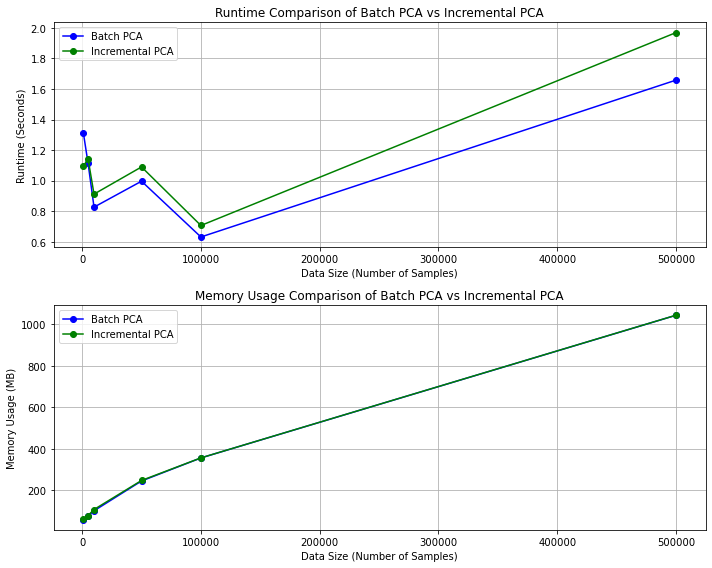

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA
from time import time
from memory_profiler import memory_usage

# Define dataset sizes
data_sizes = [1000, 5000, 10000, 50000, 100000, 500000]
n_features = 50  # Number of features in synthetic data

# Initialize lists to store results
runtime_batch, runtime_incremental = [], []
memory_batch, memory_incremental = [], []

# Function to measure runtime and memory usage
def measure_pca_runtime_memory(pca, data):
    start_time = time()
    mem_usage = memory_usage((pca.fit, (data,)), max_usage=True)
    end_time = time()
    return end_time - start_time, mem_usage

# Run PCA and IncrementalPCA for each dataset size
for size in data_sizes:
    data = np.random.rand(size, n_features)  # Generate synthetic data
    
    # Batch PCA
    pca = PCA(n_components=10)
    time_taken, mem_used = measure_pca_runtime_memory(pca, data)
    runtime_batch.append(time_taken)
    memory_batch.append(mem_used)
    
    # Incremental PCA
    inc_pca = IncrementalPCA(n_components=10, batch_size=1000)
    time_taken, mem_used = measure_pca_runtime_memory(inc_pca, data)
    runtime_incremental.append(time_taken)
    memory_incremental.append(mem_used)

# Plot results
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot runtime comparison
axs[0].plot(data_sizes, runtime_batch, label="Batch PCA", color="blue", marker="o")
axs[0].plot(data_sizes, runtime_incremental, label="Incremental PCA", color="green", marker="o")
axs[0].set_title("Runtime Comparison of Batch PCA vs Incremental PCA")
axs[0].set_xlabel("Data Size (Number of Samples)")
axs[0].set_ylabel("Runtime (Seconds)")
axs[0].legend()
axs[0].grid(True)

# Plot memory usage comparison
axs[1].plot(data_sizes, memory_batch, label="Batch PCA", color="blue", marker="o")
axs[1].plot(data_sizes, memory_incremental, label="Incremental PCA", color="green", marker="o")
axs[1].set_title("Memory Usage Comparison of Batch PCA vs Incremental PCA")
axs[1].set_xlabel("Data Size (Number of Samples)")
axs[1].set_ylabel("Memory Usage (MB)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
